Here I'd like to do the initial evaluation which of prepared 4 approaches of datasets is the most promising. The simple idea is to prepare some base ML models and evaluate their performance and choose the best approach (train and test set processing) and use it to further work.

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.6 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, 
                             recall_score, confusion_matrix, 
                             classification_report, precision_recall_curve)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import resample
from sklearn.feature_selection import RFE, SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
X_train = pd.read_csv('/content/gdrive/MyDrive/Data Science Pro/Projekt końcowy/EXTRACTED DATA/X_train_v1_1')
X_test = pd.read_csv('/content/gdrive/MyDrive/Data Science Pro/Projekt końcowy/EXTRACTED DATA/X_test_v1_1')

#y_train and y_test datasets
y_train = pd.read_csv('/content/gdrive/MyDrive/Data Science Pro/Projekt końcowy/EXTRACTED DATA/y_train')
y_test = pd.read_csv('/content/gdrive/MyDrive/Data Science Pro/Projekt końcowy/EXTRACTED DATA/y_test')

In [ ]:
#converting strings into binary values
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
def calculate_metrics(target, prediction, average='weighted'):
  auc = roc_auc_score(target, prediction)
  precision = precision_score(target, prediction, average=average)
  recall = recall_score(target, prediction, average=average)
  f1 = f1_score(target, prediction, average=average)
  cf_matrix = confusion_matrix(target, prediction)
  report = classification_report(target, prediction)
  
  return auc, precision, recall, f1, cf_matrix, report

In [ ]:
def print_results(metrics, classifier_id='classifier'):
  print(f'Results for {classifier_id}')
  print('-----')
  print(f'   AUC:  {metrics[0]}')
  print(f'   Precision:  {metrics[1]}')
  print(f'   Recall:  {metrics[2]}')
  print(f'   F1:  {metrics[3]}')
  print('-----')
  sns.heatmap(metrics[4], annot=True, cmap='Blues')
  plt.title('Confusion Matrix')
  plt.show()
  print('-----')
  print('Classification report:')
  print(metrics[5])


In [ ]:
def pred_eval(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
  '''
  Initial evaluation of processed data based on two basic alghorithms:
  LogisticRegression and RandomFroest.
  '''
  #LogisticRegression
  LogReg = LogisticRegression()
  LogReg.fit(X_train, y_train)
  y_pred_LogReg = LogReg.predict(X_test)
  print('LogisticRegression report')
  print(classification_report(
      y_test, 
      y_pred_LogReg, 
      target_names=['Normal', 'Warning']
  ))
  print(f'AUC: {roc_auc_score(y_test, y_pred_LogReg)}')
  print('-------')

  #RandomForest
  RanFor = RandomForestClassifier(n_estimators=60)
  RanFor.fit(X_train, y_train)
  y_pred_RanFor = RanFor.predict(X_test)
  print('RandomForest report')
  print(classification_report(
      y_test, 
      y_pred_RanFor,
       target_names=['Normal', 'Warning']
  ))
  print(f'AUC: {roc_auc_score(y_test, y_pred_RanFor)}')
  print('-------')

## Data scaling

In [ ]:
cat_cols = ['latest_seismic_assessment', 'latest_seismoacoustic_assessment', 
            'latest_comprehensive_assessment', 'latest_hazards_assessment']

In [ ]:
numeric_X_train = X_train.drop(cat_cols, axis=1).reset_index(drop=True)
numeric_X_test = X_test.drop(cat_cols, axis=1).reset_index(drop=True)

In [ ]:
#trainval
numeric_X_train = X_train.drop(cat_cols, axis=1).reset_index(drop=True)

In [ ]:
scaler = StandardScaler()

#X_train scaling
scaled_data_train = scaler.fit_transform(numeric_X_train)
scaled_data_train = pd.DataFrame(scaled_data_train, columns=numeric_X_train.columns)
X_train = pd.concat([scaled_data_train, X_train[cat_cols].reset_index(drop=True)], axis=1)

#X_test scaling
scaled_data_test = scaler.transform(numeric_X_test)
scaled_data_test = pd.DataFrame(scaled_data_test, columns=numeric_X_test.columns)
X_test = pd.concat([scaled_data_test, X_test[cat_cols].reset_index(drop=True)], axis=1)

## Class balancing

### 1. Without resampling

In [ ]:
#Initial state - Logistic Regression and RandomForest alghorithms
pred_eval(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.54      0.14      0.23       196

    accuracy                           0.95      3860
   macro avg       0.75      0.57      0.60      3860
weighted avg       0.93      0.95      0.94      3860

AUC: 0.5681534622582658
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97      3664
     Warning       0.50      0.01      0.01       196

    accuracy                           0.95      3860
   macro avg       0.72      0.50      0.49      3860
weighted avg       0.93      0.95      0.93      3860

AUC: 0.5024145575260672
-------


## 2. Resampling - SMOTE

In [ ]:
#Testing different k_neighbors parametrs and comparing LogisticRegression and 
#RandomForest metrics to find the best one.
for i in range(2, 9):
  sm = SMOTE(sampling_strategy='auto', k_neighbors=i, random_state=42)
  Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)
  print(f'Scores for {i} k_neighbors:')
  pred_eval(Xsm_train, X_test, ysm_train, y_test)

Scores for 2 k_neighbors:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93      3664
     Warning       0.26      0.80      0.40       196

    accuracy                           0.88      3860
   macro avg       0.63      0.84      0.66      3860
weighted avg       0.95      0.88      0.90      3860

AUC: 0.8388707557258711
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.53      0.18      0.27       196

    accuracy                           0.95      3860
   macro avg       0.74      0.59      0.62      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.5850553649407362
-------
Scores for 3 k_neighbors:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93      3664
     Warning       0.27      0.81      0.40       196

    accuracy                           0.88      3860
   macro avg       0.63      0.85      0.67      3860
weighted avg       0.95      0.88      0.90      3860

AUC: 0.8454321138935923
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.48      0.20      0.29       196

    accuracy                           0.95      3860
   macro avg       0.72      0.60      0.63      3860
weighted avg       0.93      0.95      0.94      3860

AUC: 0.5961729123963997
-------
Scores for 4 k_neighbors:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93      3664
     Warning       0.26      0.82      0.40       196

    accuracy                           0.88      3860
   macro avg       0.63      0.85      0.66      3860
weighted avg       0.95      0.88      0.90      3860

AUC: 0.8474372827733715
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.49      0.22      0.31       196

    accuracy                           0.95      3860
   macro avg       0.73      0.61      0.64      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.6061040682648605
-------
Scores for 5 k_neighbors:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93      3664
     Warning       0.26      0.81      0.40       196

    accuracy                           0.87      3860
   macro avg       0.63      0.84      0.66      3860
weighted avg       0.95      0.87      0.90      3860

AUC: 0.8443404108368238
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.49      0.25      0.33       196

    accuracy                           0.95      3860
   macro avg       0.73      0.62      0.65      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.6181768558951964
-------
Scores for 6 k_neighbors:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93      3664
     Warning       0.26      0.82      0.40       196

    accuracy                           0.87      3860
   macro avg       0.62      0.85      0.66      3860
weighted avg       0.95      0.87      0.90      3860

AUC: 0.8462091168345067
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.49      0.27      0.34       196

    accuracy                           0.95      3860
   macro avg       0.73      0.63      0.66      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.6252840655913021
-------
Scores for 7 k_neighbors:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93      3664
     Warning       0.26      0.82      0.40       196

    accuracy                           0.87      3860
   macro avg       0.62      0.85      0.66      3860
weighted avg       0.95      0.87      0.90      3860

AUC: 0.8483507485963818
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      3664
     Warning       0.47      0.30      0.36       196

    accuracy                           0.95      3860
   macro avg       0.72      0.64      0.67      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.6390890963372248
-------
Scores for 8 k_neighbors:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.99      0.87      0.93      3664
     Warning       0.26      0.82      0.39       196

    accuracy                           0.87      3860
   macro avg       0.62      0.85      0.66      3860
weighted avg       0.95      0.87      0.90      3860

AUC: 0.8453903395419303
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      3664
     Warning       0.46      0.26      0.33       196

    accuracy                           0.95      3860
   macro avg       0.71      0.62      0.65      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.6220507307726584
-------


Above we've tested different k-neighbors used for new samples of minority class creation. To the further works the best SMOTE configuration is with k-neighbors parameter equal to <b>8</b>, beacouse there is the highest recall score and high AUC score for RandomForest (LogReg performance is nearly the same for all approaches of SMOTE).

In [ ]:
sampling_strategy = [0.1, 0.2, 0.3, 0.4]
for i in range(len(sampling_strategy)):
  sm = SMOTE(
      sampling_strategy=sampling_strategy[i], k_neighbors=8, 
      random_state=42)
  Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)
  print(f'Scores for {sampling_strategy[i]} sampling_strategy:')
  pred_eval(Xsm_train, X_test, ysm_train, y_test)

Scores for 0.1 sampling_strategy:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97      3664
     Warning       0.45      0.32      0.38       196

    accuracy                           0.95      3860
   macro avg       0.71      0.65      0.67      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.6502066437928883
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97      3664
     Warning       0.49      0.11      0.18       196

    accuracy                           0.95      3860
   macro avg       0.72      0.55      0.57      3860
weighted avg       0.93      0.95      0.93      3860

AUC: 0.550569245165315
-------
Scores for 0.2 sampling_strategy:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96      3664
     Warning       0.36      0.48      0.41       196

    accuracy                           0.93      3860
   macro avg       0.67      0.72      0.69      3860
weighted avg       0.94      0.93      0.94      3860

AUC: 0.7171430799393993
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.53      0.18      0.27       196

    accuracy                           0.95      3860
   macro avg       0.74      0.59      0.62      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.5850553649407362
-------
Scores for 0.3 sampling_strategy:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96      3664
     Warning       0.34      0.63      0.44       196

    accuracy                           0.92      3860
   macro avg       0.66      0.78      0.70      3860
weighted avg       0.95      0.92      0.93      3860

AUC: 0.781433807147313
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.47      0.19      0.28       196

    accuracy                           0.95      3860
   macro avg       0.72      0.59      0.62      3860
weighted avg       0.93      0.95      0.94      3860

AUC: 0.5912073344621691
-------
Scores for 0.4 sampling_strategy:


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.98      0.92      0.95      3664
     Warning       0.31      0.67      0.43       196

    accuracy                           0.91      3860
   macro avg       0.65      0.80      0.69      3860
weighted avg       0.95      0.91      0.92      3860

AUC: 0.7951552891899117
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.99      0.97      3664
     Warning       0.52      0.27      0.36       196

    accuracy                           0.95      3860
   macro avg       0.74      0.63      0.66      3860
weighted avg       0.94      0.95      0.94      3860

AUC: 0.6285174004099456
-------


## Resampling - ADASYN

In [ ]:
ads = ADASYN(sampling_strategy='auto', n_neighbors=8, random_state=42)
Xads, yads = ads.fit_resample(X_train, y_train)

In [ ]:
pred_eval(Xads, X_test, yads, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression report
              precision    recall  f1-score   support

      Normal       1.00      0.90      0.95     26038
     Warning       0.17      0.89      0.29       593

    accuracy                           0.90     26631
   macro avg       0.58      0.90      0.62     26631
weighted avg       0.98      0.90      0.93     26631

AUC: 0.8963614535611268
-------
RandomForest report
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     26038
     Warning       0.54      0.57      0.55       593

    accuracy                           0.98     26631
   macro avg       0.76      0.78      0.77     26631
weighted avg       0.98      0.98      0.98     26631

AUC: 0.7777748489786688
-------


We can noticed worse performance than SMOTE.

### Combination of oversampling and undersampling (SMOTE and RandomUnderSampler)

In [ ]:
under = RandomUnderSampler(sampling_strategy = 'auto', random_state=42)
sm = SMOTE(sampling_strategy=0.25, k_neighbors=8, random_state=42)

model = LogisticRegression()

steps = [
    ('sm', sm), 
    ('under', under), 
    ('model', model)
]

pipeline = make_pipeline(
    sm,
    under,
    model
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     26038
           1       0.17      0.89      0.29       593

    accuracy                           0.90     26631
   macro avg       0.59      0.90      0.62     26631
weighted avg       0.98      0.90      0.93     26631



/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Worse performance than SMOTE.

Other methods of resampling were tried to be tested, however they didn't compute, beacouse of huge dataset (SMOTETomek Links, SMOTEENN, etc.)

In [ ]:
sm = SMOTE(sampling_strategy='auto', k_neighbors=8, random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

# Feature selection

In [ ]:
def cor_selector(X, y, num_feats: int):
  '''
Calculating Pearson correlation between each feature and prediction. Finding the 
most important features basing on correlation.
  '''
  cor_list = []
  features = X.columns.tolist()
  for feature in features:
    cor = np.corrcoef(X[feature], y)[0, 1]
    cor_list.append(cor)
  #Nan -> 0
  cor_list = [0 if np.isnan(i) else i for i in cor_list]
  cor_feature = X.iloc[:, 
                       np.argsort(np.abs(cor_list))
                       [-num_feats: ]
                       ].columns.tolist()
  #feature selection
  cor_support = [True if i in cor_feature else False for i in features]
  
  return cor_support, cor_feature


In [ ]:
def RFE_selector(X, y, num_feats):
  'Finding the most important features basing on recursive feature elimination'

  rfe_selector = RFE(
      estimator=LogisticRegression(), n_features_to_select=num_feats, 
      step=10)
  rfe_selector.fit(X, y)
  rfe_support = rfe_selector.get_support()
  rfe_feature = X.loc[:, rfe_support].columns.tolist()
  
  return rfe_support, rfe_feature

In [ ]:
def Lasso_selector(X, y, num_feats):
  '''
  Finding the most important features basing on meta-transformer 
  that used alongside Logistic Regression estimator that assigns importance 
  to each feature.
  '''

  lr_selector = SelectFromModel(
      LogisticRegression(penalty='l2'), max_features=num_feats)
  lr_selector.fit(X, y)
  lr_support = lr_selector.get_support()
  lr_feature = X.loc[:, lr_support].columns.tolist()

  return lr_support, lr_feature

In [ ]:
def RanFor_selector(X, y, num_feats):
  '''
  Finding the most important features basing on meta-transformer 
  that used alongside Random Forest estimator that assigns importance 
  to each feature.
  '''

  rf_selector = SelectFromModel(
      RandomForestClassifier(n_estimators=60), max_features=num_feats)
  rf_selector.fit(X, y)
  rf_support = rf_selector.get_support()
  rf_feature = X.loc[:, rf_support].columns.tolist()

  return rf_support, rf_feature

In [ ]:
def LGBMC_optimizer(X, y, num_feats, selector=False):
  '''
  Finding best LGBMClassifier hyperparameters for SelectFromModel
  feature selection
  '''

  lgbc = LGBMClassifier()

  max_depth = [-1, 0, 1, 5, 20]
  num_leaves = [1, 2, 16 ,32]
  reg_lambda = [0, 1, 5, 10, 25, 100]
  learning_rate = [0.01, 0.05, 0.1, 1]
  min_gain_to_split = [0, 0.1, 1]
  min_child_weight = [1e-3, 1e-1, 0, 10, 40]

  params = {
      'max_depth': max_depth,
      'num_leaves': num_leaves,
      'reg_lambda': reg_lambda,
      'learning_rate': learning_rate,
      'min_gain_to_split': min_gain_to_split,
      'min_child_weight': min_child_weight,
  }

  kfold = StratifiedKFold(3, shuffle=True, random_state=42)
  optimizer = RandomizedSearchCV(estimator=lgbc,
                                 param_distributions=params,
                                 scoring='f1',
                                 cv=kfold)
  optimizer.fit(X, y)

  return optimizer.best_params_, optimizer.best_estimator_


In [ ]:
def LGBMC_selector(X, y, num_feats, optimization=False):
  '''
  Finding the most important features basing on meta-transformer 
  that used alongside LGBMClassifier that assigns importance 
  to each feature.
  If optimization = False it is base LGBClassifier without optimizing
  hyperparameters. Setting it to True runs LGBMC_optimizer function.
  '''

  if optimization:
    best_params, lgbc = LGBMC_optimizer(X, y, num_feats, selector=True)
  else:
    lgbc = LGBMClassifier()
  lgbc_selector = SelectFromModel(lgbc, max_features=num_feats)
  lgbc_selector.fit(X, y)
  lgbc_support = lgbc_selector.get_support()
  lgbc_feature = X.loc[:, lgbc_support].columns.tolist()

  return lgbc_support, lgbc_feature

In [ ]:
cor_support, cor_feature = cor_selector(Xsm_train, ysm_train, 50)

In [ ]:
rfe_support, rfe_feature = RFE_selector(Xsm_train, ysm_train, 50)

In [ ]:
lasso_support, lasso_feature = Lasso_selector(Xsm_train, ysm_train, 50)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
rf_support, rf_feature = RanFor_selector(Xsm_train, ysm_train, 50)

In [ ]:
lgbc_support, lgbc_feature = LGBMC_selector(Xsm_train, ysm_train, 50, optimization=True)

In [ ]:
feature_name = list(Xsm_train.columns)
pd.set_option('display.max_rows', None)
feature_selection_df = pd.DataFrame({
     'Feature': feature_name, 
     'Pearson': cor_support, 
     'RFE': rfe_support, 
     'Random Forest': rf_support, 
     'LightGBM': lgbc_support
})

feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(
    ['Total', 'Feature'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(150)

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


,Feature,Pearson,RFE,Random Forest,LightGBM,Total
1,latest_seismic_assessment,True,True,True,True,4
2,5_avg_max_gactivity,True,True,True,True,4
3,24h_std_max_gactivity,True,True,True,True,4
4,sum_highest_bump_energy,False,True,True,True,3
5,sum_count_e4,True,False,True,True,3
6,sum_count_e3,True,False,True,True,3
7,max_gactivity.24,True,False,True,True,3
8,latest_maximum_yield,False,True,True,True,3
9,latest_maximum_meter,False,True,True,True,3
10,24h_max_max_gactivity,True,False,True,True,3


In [ ]:
#Methodology of selecting features I addopted assuming that at least 2 selection
# methods from all 4 have to point out feature to be included to final dataset
imp_features = feature_selection_df[feature_selection_df['Total'] > 1
                                    ]['Feature'].values

In [ ]:
#Assigning only important features to the datasets
X_train = Xsm_train[imp_features]
X_test = X_test[imp_features]
y_train = ysm_train

# Dimensionality reduction

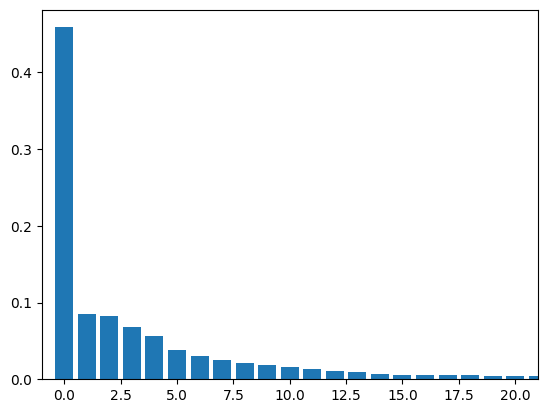

In [ ]:
pca = PCA()
pca.fit(X_train)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlim(-1, 21)
plt.show()

In [ ]:
num_components = 1

Conclusion: 1 principal component vector should enough.

In [ ]:
X_train_pca = pca.transform(X_train)[:, :num_components]
X_test_pca = pca.transform(X_test)[:, :num_components]

In [ ]:
pred_eval(X_train_pca, X_test_pca, y_train, y_test)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression report
              precision    recall  f1-score   support

      Normal       0.98      0.91      0.94      3664
     Warning       0.27      0.58      0.36       196

    accuracy                           0.90      3860
   macro avg       0.62      0.75      0.65      3860
weighted avg       0.94      0.90      0.91      3860

AUC: 0.745552424026379
-------


<ipython-input-7-8c6edf65c1a8>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RanFor.fit(X_train, y_train)


RandomForest report
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97      3664
     Warning       0.35      0.32      0.33       196

    accuracy                           0.93      3860
   macro avg       0.65      0.64      0.65      3860
weighted avg       0.93      0.93      0.93      3860

AUC: 0.6444752027448534
-------


Conclusion: PCA does not help. After many trials and errors metrics are always significatnly worse results than without dimensionality reduction. 

# Model

In this section I'll be testing a few alghoritms to find the best one. Main evaluation score I've selected are: recall  of class 'warning' (in coal main people safety are the most important) and roc_auc and next possibly high precision (to not interrupt works too often). Typed alghorithms are:
* Logistic Regression
* Random Forest
* LightGBM
* CatBoostClassifier
* XGBOOST


## Prediction treshold balance

It'll be helpful to adjust treshold in best models to find optimal recall - precision balance.

In [ ]:
def threshold_balance (estimator, X_test=X_test, y_test=y_test, threshold = 0.5):

  threshold = threshold

  fig = plt.subplots(figsize=(8, 6))
  precision_gd, recall_gd, thresholds_gd = precision_recall_curve(
      y_test, estimator.predict_proba(X_test)[:, 1])
  plt.plot(precision_gd, recall_gd, label='gd')

  close_default_gd = np.argmin(np.abs(thresholds_gd - threshold))
  plt.plot(precision_gd[close_default_gd], recall_gd[close_default_gd], '^', c='k', 
          markersize=10, label=f'threshold {threshold}', fillstyle='none', mew=2)

  plt.xlabel('Precision')
  plt.ylabel('Recall')
  plt.legend(loc='best')
  plt.grid(alpha=0.4)
  plt.show()

## 1. Logistic Regression

In [ ]:
kfold = StratifiedKFold(5, shuffle=False)

In [ ]:
model_lr = LogisticRegression(max_iter=100000)

#params for hyperparameters optimization
params = [
    {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga']
    },
    {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1],
    'solver': ['lbfgs']
    }
]

optimizer_lr = RandomizedSearchCV(estimator=model_lr,
                            param_distributions=params,
                            scoring='roc_auc',
                            cv=kfold,
                            n_iter=20,
                            n_jobs=-1
)

In [ ]:
optimizer_lr.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(max_iter=100000), n_iter=20,
                   n_jobs=-1,
                   param_distributions=[{'C': [0.1, 1, 10, 100, 1000],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['liblinear', 'saga']},
                                        {'C': [0.001, 0.01, 0.1],
                                         'penalty': ['l2'],
                                         'solver': ['lbfgs']}],
                   scoring='roc_auc')

In [ ]:
lr_best_params = optimizer_lr.best_params_
lr_best_params

{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.001}

In [ ]:
y_test_pred = optimizer_lr.best_estimator_.predict(X_test)
lr_metrics_test = calculate_metrics(y_test, y_test_pred)
print_results(lr_metrics_test)

In [ ]:
#creating model with best hyperparameters
lr_model = LogisticRegression(
    max_iter=100000, solver='lbfgs', 
    penalty='l2', C=0.001)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#scoring model with cross-validation
#based on printed results - the model is on the verge of overfitting,
#but it is acceptable
score_lr = cross_val_score(lr_model, scoring='roc_auc', X=X_train, y=y_train, cv=5)
score_lr

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

array([0.94126968, 0.92049952, 0.90460821, 0.93777032, 0.88823783])

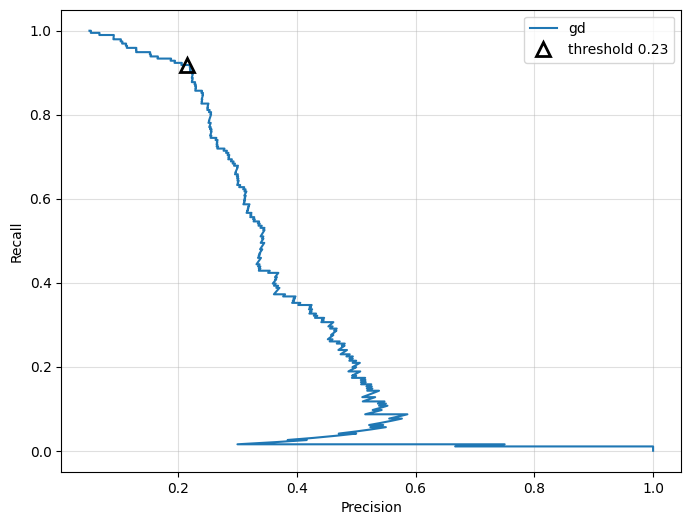

In [ ]:
#after some trial and error optimal threshold, in my opinion, thinking about 
#the safety of work in the mine, will be 0.23 

threshold_balance(lr_model, threshold = 0.23)

Results for classifier
-----
   AUC:  0.8699369485785581
   Precision:  0.9551628829021753
   Recall:  0.8264248704663213
   F1:  0.8719060029170502
-----


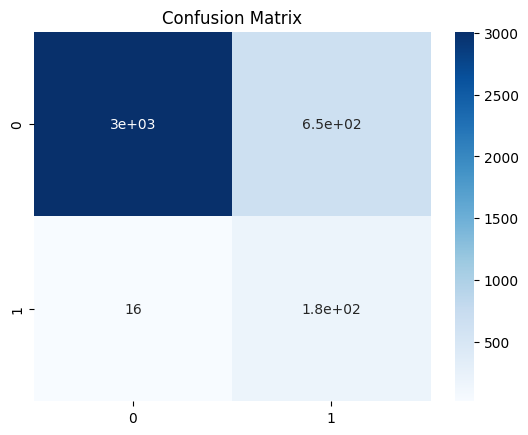

-----
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      3664
           1       0.22      0.92      0.35       196

    accuracy                           0.83      3860
   macro avg       0.61      0.87      0.62      3860
weighted avg       0.96      0.83      0.87      3860



In [ ]:
#prediction for different threshold
y_pred_lr_th = (lr_model.predict_proba(X_test)[:, 1] > 0.23).astype(int)
metric_lr_th = calculate_metrics(y_test, y_pred_lr_th)
print_results(metric_lr_th)

# 2. RandomForest

In [ ]:
kfold = StratifiedKFold(5, shuffle=False)

model_rf = RandomForestClassifier()

#params for hyperparameters optimization
n_estimators = [60, 200, 500, 700]
min_samples_leaf = [2, 5, 10]
min_samples_split = [2, 6, 12]
max_depth = [2, 5, 10, 20, 30, 40, 50]
criterion = ['gini', 'entropy']
max_features = ['auto', 'sqrt']

params = {
    'n_estimators': n_estimators,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_depth': max_depth,
    'criterion': criterion,
    'max_features': max_features

}


optimizer_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=params,
    scoring='roc_auc',
    cv=kfold,
    n_jobs=-1
)

optimizer_rf.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [2, 6, 12],
                                        'n_estimators': [60, 200, 500, 700]},
                   scoring='roc_auc')

In [ ]:
best_params_rf = optimizer_rf.best_params_
best_params_rf

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'gini'}

In [ ]:
score_rf = cross_val_score(optimizer_rf.best_estimator_, X=X_train, y=y_train, cv=5)
score_rf

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureW

Results for classifier
-----
   AUC:  0.70634023259959
   Precision:  0.9412702815521463
   Recall:  0.9375647668393783
   F1:  0.9393294608579988
-----


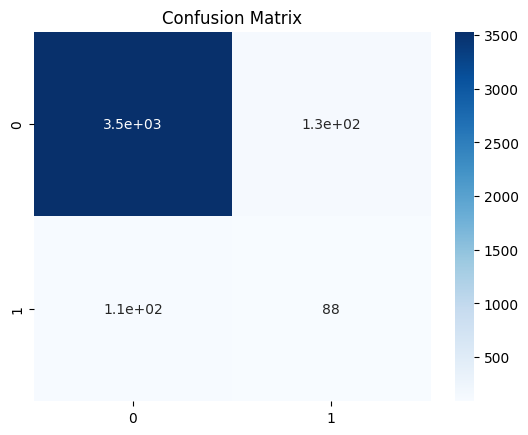

-----
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3664
           1       0.40      0.45      0.42       196

    accuracy                           0.94      3860
   macro avg       0.68      0.71      0.69      3860
weighted avg       0.94      0.94      0.94      3860



In [ ]:
y_pred_rf_test = optimizer_rf.best_estimator_.predict(X_test)
rf_metrics_test = calculate_metrics(y_test, y_pred_rf_test)
print_results(rf_metrics_test)

In [ ]:
#RandomForest model with best params
rf_model = RandomForestClassifier(
    n_estimators=500, min_samples_split=2, 
    min_samples_leaf=2, max_features='auto',
    max_depth=20, criterion='gini')

rf_model.fit(X_train, y_train)

<ipython-input-13-4f8b5e2d01db>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=2,
                       n_estimators=500)

In [ ]:
#model is not overfitted
score_rf = cross_val_score(rf_model, X=X_train, y=y_train, scoring='roc_auc', cv=5)
score_rf

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:424: FutureW

array([0.98924676, 0.98305207, 0.98119179, 0.9952097 , 0.97582262])

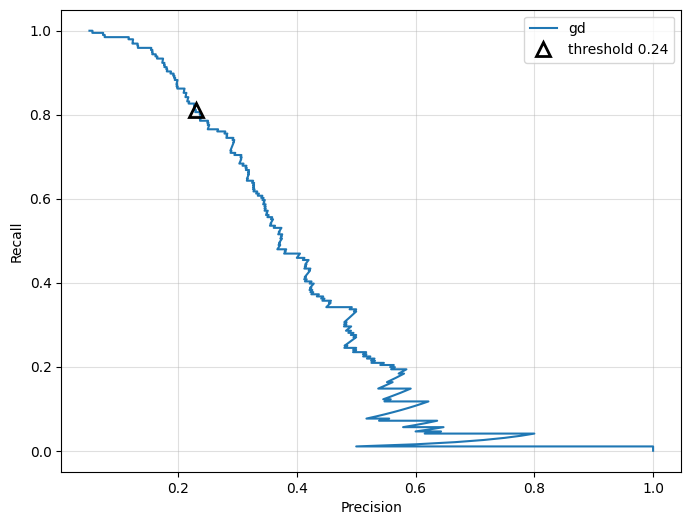

In [ ]:
threshold_balance(rf_model, threshold = 0.24)

Results worse than in Logistic Regression.

#3. LightGBM

In [ ]:
kfold = StratifiedKFold(10, shuffle=True, random_state=42)
model_lgbm = LGBMClassifier()

#params for hyperparameters optimization
boosting_type = ['gbdt', 'goss']
max_depth = [ 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]
num_leaves = [4, 17, 25, 50, 70, 1500, 2000, 2500, 3000]
min_data_in_leaf = [250, 500, 750, 1200, 2000, 3000]
num_iterations = [60, 80, 150, 200]
learning_rate = [0.01, 0.03, 0.05, 0.1, 0.5]
early_stopping_round = [5, 15]
lambda_l1 = [0.1, 1, 10, 100, 1000]
lambda_l2 = [0.1, 1, 10, 100, 1000]

params = {
    'boosting_type': boosting_type,
    'max_depth': max_depth,
    'num_leaves': num_leaves,
    'min_data_in_leaf': min_data_in_leaf,
    'num_iterations': num_iterations,
    'learning_rate': learning_rate,
    'lambda_l1': lambda_l1,
    'lambda_l2': lambda_l2,
}

optimizer_lgbm = RandomizedSearchCV(
    estimator=model_lgbm,
    param_distributions=params,
    scoring='roc_auc',
    cv = kfold
)

optimizer_lgbm.fit(X_train, y_train)

In [ ]:
lgbm_best_params = optimizer_lgbm.best_params_
lgbm_best_params

{'num_leaves': 1500,
 'num_iterations': 80,
 'min_data_in_leaf': 750,
 'max_depth': 22,
 'learning_rate': 0.03,
 'lambda_l2': 10,
 'lambda_l1': 1,
 'boosting_type': 'gbdt'}

In [ ]:
scores_lgbm = cross_val_score(
    optimizer_lgbm.best_estimator_, X=X_train, 
    y=y_train, cv=5)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


Results for classifier
-----
   AUC:  0.6923569646199091
   Precision:  0.9384457795737879
   Recall:  0.9339378238341969
   F1:  0.9360818870697463
-----


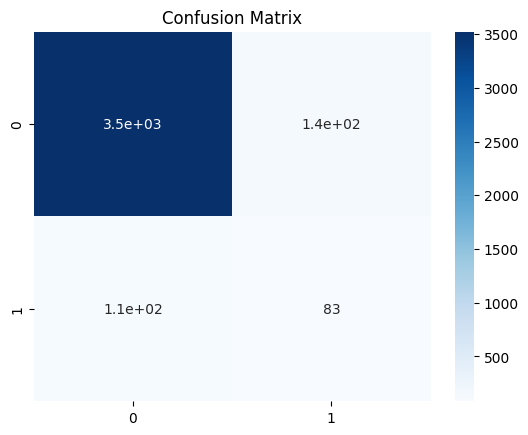

-----
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3664
           1       0.37      0.42      0.39       196

    accuracy                           0.93      3860
   macro avg       0.67      0.69      0.68      3860
weighted avg       0.94      0.93      0.94      3860



In [ ]:
y_pred_test_lgbm = optimizer_lgbm.best_estimator_.predict(X_test)
lgbm_metrics = calculate_metrics(y_test, y_pred_test_lgbm)
print_results(lgbm_metrics)

In [ ]:
#creating model with best params
model_lgbm = LGBMClassifier(
    num_leaves=1500, num_iterations=80, 
    min_data_in_leaf=750, max_depth=22,
    learning_rate=0.03, lambda_l2=10,
    lambda_l1=1, boosting_type='gbdt'
)

model_lgbm.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


LGBMClassifier(lambda_l1=1, lambda_l2=10, learning_rate=0.03, max_depth=22,
               min_data_in_leaf=750, num_iterations=80, num_leaves=1500)

In [ ]:
scores_lgbm = cross_val_score(
    model_lgbm, X=X_train, 
    y=y_train, scoring='roc_auc', cv=5)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=750, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=750
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


In [ ]:
#not overfitted
scores_lgbm

array([0.97746274, 0.95910199, 0.94406783, 0.98261627, 0.965622  ])

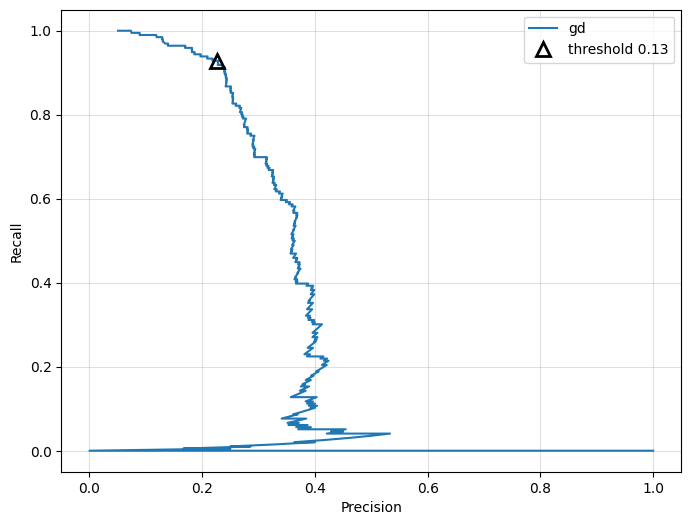

In [ ]:
threshold_balance(model_lgbm, threshold=0.13)

Results for classifier
-----
   AUC:  0.8795422645040549
   Precision:  0.9563843426628381
   Recall:  0.8354922279792746
   F1:  0.8780416422352262
-----


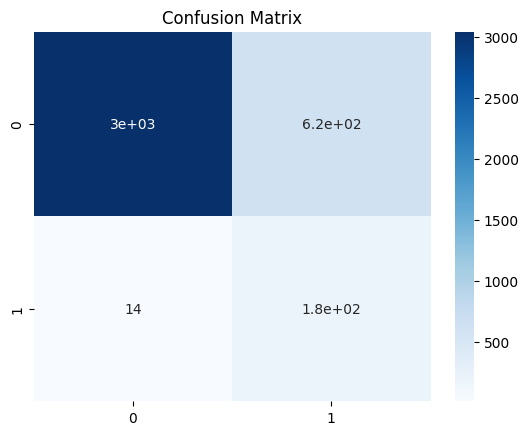

-----
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3664
           1       0.23      0.93      0.36       196

    accuracy                           0.84      3860
   macro avg       0.61      0.88      0.63      3860
weighted avg       0.96      0.84      0.88      3860



In [ ]:
#prediction for different threshold
y_pred_lgbm_th = (model_lgbm.predict_proba(X_test)[:, 1] > 0.13).astype(int)
metric_lgbm_th = calculate_metrics(y_test, y_pred_lgbm_th)
print_results(metric_lgbm_th)

# CatBoostClassifier

In [ ]:
cat_cols = [
    'latest_seismic_assessment', 'latest_comprehensive_assessment', 
    'latest_hazards_assessment'
]

kfold = StratifiedKFold(10, shuffle=False)
model_catboost = CatBoostClassifier(task_type = 'GPU', cat_features=cat_cols)

learning_rate = [0.01, 0.05, 0.1, 0.5, 0.8],
depth = np.arange(2, 8)
l2_leaf_reg = [10, 100, 1000, 10000],
random_strength = [1, 5, 10],
iterations = [100, 500, 1000],
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']

 
#2
grow_policy = ['SymmetricTree'],
min_data_in_leaf = [1, 3, 5, 7, 9]

#3
grow_policy = ['Lossguide']
max_leaves = [31, 35, 40, 45, 50, 55]

params = [
    {
      'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.8],
      'depth': np.arange(2, 8),
      'l2_leaf_reg': [1, 10, 100, 1000, 10000],
      'random_strength': [1, 3, 6, 10],
      'iterations': np.arange(100, 1001, 50),
      'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
    },
    {
      'grow_policy': ['SymmetricTree'],
      'min_data_in_leaf': [1, 3, 5, 7, 9],
      'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.8],
      'iterations': np.arange(100, 1001, 50),
      'depth': np.arange(2, 8)
    },
    {
      'grow_policy': ['Lossguide'],
      'max_leaves': [31, 35, 40, 45, 50, 55],
      'learning_rate': [0.01, 0.05, 0.1, 0.5, 0.8],
      'iterations': np.arange(100, 1001, 50),
      'depth': np.arange(2, 8)
    }
]


optimizer_catboost = RandomizedSearchCV(
    estimator=model_catboost,
    param_distributions=params,
    scoring='roc_auc',
    cv = kfold,
    n_iter = 20
)

optimizer_catboost.fit(X_train, y_train)

In [ ]:
catboost_best_params = optimizer_catboost.best_params_

Results for classifier
-----
   AUC:  0.574945971838517
   Precision:  0.9280888178901515
   Recall:  0.944818652849741
   F1:  0.9337903379275583
-----


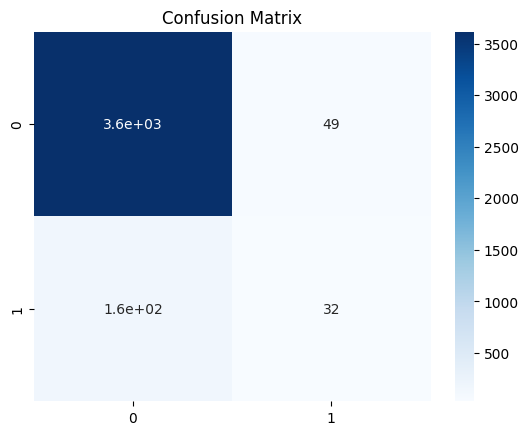

-----
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3664
           1       0.40      0.16      0.23       196

    accuracy                           0.94      3860
   macro avg       0.68      0.57      0.60      3860
weighted avg       0.93      0.94      0.93      3860



In [ ]:
y_pred_test_catboost = optimizer_catboost.best_estimator_.predict(X_test)
catboost_metrics = calculate_metrics(y_test, y_pred_test_catboost)
print_results(catboost_metrics)

CatboostClassifier gives us bad results so there will be no further steps.

# XGBoost

In [ ]:
booster = ['gbtree', 'gblinear', 'dart']
eta = [0.01, 0.1, 0.5, 0.8]
gamma = [0, 0.1, 1, 10]
n_estimators = [60, 120, 200, 300, 500]
min_child_weight = [0, 1, 4, 6, 10]
max_delta_step = [0, 1, 3, 5, 7, 10]
max_depth = [0, 1, 3, 5, 7, 10]
reg_lambda = [0.1, 1, 10, 100]
reg_alpha = [0, 0.1, 1, 10, 100]
scale_pos_weight = [1, 3, 5, 7, 10]

model_xgb = XGBClassifier()

params = {
    'booster': booster,
    'eta': eta,
    'gamma': gamma,
    'n_estimators': n_estimators,
    'min_child_weight': min_child_weight,
    'max_delta_step': max_delta_step,
    'max_depth': max_depth,
    'reg_lambda': reg_lambda,
    'reg_alpha': reg_alpha,
    'scale_pos_weight': scale_pos_weight
}

optimizer_xgb = RandomizedSearchCV(
    estimator = model_xgb,
    param_distributions = params,
    cv = kfold,
    scoring = 'roc_auc'
)

optimizer_xgb.fit(X_train, y_train)

In [ ]:
best_xgb_params = optimizer_xgb.best_params_
best_xgb_params

{'scale_pos_weight': 7,
 'reg_lambda': 10,
 'reg_alpha': 100,
 'n_estimators': 200,
 'min_child_weight': 0,
 'max_depth': 3,
 'max_delta_step': 0,
 'gamma': 0.1,
 'eta': 0.1,
 'booster': 'dart'}

Results for classifier
-----
   AUC:  0.8192173157472596
   Precision:  0.9495742497946562
   Recall:  0.899740932642487
   F1:  0.9186727675237626
-----


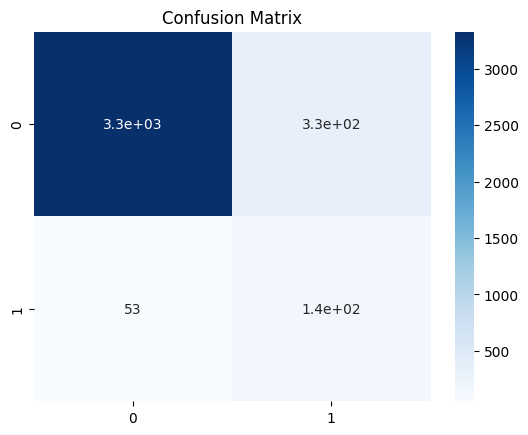

-----
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      3664
           1       0.30      0.73      0.42       196

    accuracy                           0.90      3860
   macro avg       0.64      0.82      0.69      3860
weighted avg       0.95      0.90      0.92      3860



In [ ]:
y_pred_xgb = optimizer_xgb.best_estimator_.predict(X_test)
xgb_metrics = calculate_metrics(y_test, y_pred_xgb)
print_results(xgb_metrics)

In [ ]:
#creating model with best params
model_xgb = XGBClassifier(
    scale_pos_weight=7, reg_lambda=10, 
    reg_alpha=100, n_estimators=200,
    min_child_weight=0, max_depth=3,
    max_delta_step=0, gamma=0.1,
    eta=0.1, booster='dart'
)

model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=0, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
scores_xgb = cross_val_score(
    model_xgb, X=X_train,
    y=y_train, scoring='roc_auc', 
    cv=5
)
scores_xgb

array([0.98246664, 0.98165375, 0.96905417, 0.99281286, 0.98203362])

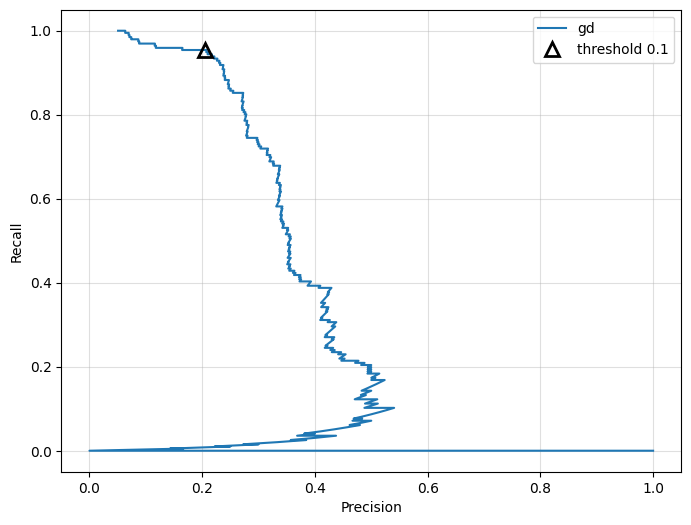

In [ ]:
threshold_balance(model_xgb, threshold=0.1)

Results for classifier
-----
   AUC:  0.8776958381605917
   Precision:  0.9566993645258248
   Recall:  0.8090673575129533
   F1:  0.8604639116196894
-----


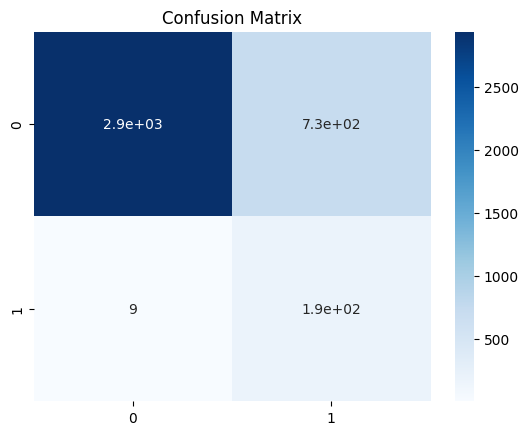

-----
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      3664
           1       0.20      0.95      0.34       196

    accuracy                           0.81      3860
   macro avg       0.60      0.88      0.61      3860
weighted avg       0.96      0.81      0.86      3860



In [ ]:
#prediction for different threshold
y_pred_xgb_th = (model_xgb.predict_proba(X_test)[:, 1] > 0.1).astype(int)
metric_xgb_th = calculate_metrics(y_test, y_pred_xgb_th)
print_results(metric_xgb_th)

# Summary

In the above experiments I've used previously prepared and initially preprocessed datasets to prepare models. I've made also some operations before experiment with models:

* data scaling -> StandardScaler
* feature selection -> my methodology to choose the most important features based on: Pearson correlation, recursive feature elimination (RFE), SelectFromModel (Logistic Regressien and RandomForest alghorithms). It was crucial part as initial dataset was large (over 600 features). If 2 of 4 methods pointed out that feature is important - it'll be used for model experiments.
* dimensionality reduction -> PCA. Gives poor results. This step was abandoned. 

Model experiments:
* 5 models were used for experiments: Logistic Regression, Random Forest Classifier, LightGBM Classifier, Catboost Classifier, XGBOOST Classifier.
* 2 of these 5 Classifiers were rejected first, as they had given hopeless results (Catboost and Random Forest).
* 3 of all exhibit good overall results. It should be mentioned, that Logistic Regression showed slightly worse cross validation score results than 2 other models. However, none of the models were overfitted.
* Final choice of alghorithm depends on the business need and should be consulted with business before implementation.
* Nothwithstanding this, in my view in active coal mine safety of workers is on the first place, so a key metric are both <b>ROC AUC</b> and <b>recall</b>, much more important than precision. It results in detecting more True Positives (Warnings in this case), even if much of positives are False Positives. On the other hand, I was guided by not too low precision, as it results in stopping works in mine too often. 
* Accoring to above, the best model was <b>LightGBMClassifier</b>. It exbibits highest roc_auc_score (~0.88), 0.93 recall of class 1 and 0.23 precision of class 1. Close there were XGBOOST with even higher recall (0.95), but lower precision (0.2) and roc_auc and a bit worse LogisticRegression. The winning alghoritm has another advantage - it learns really fast.

Final model: <b>LightGBM Classifier</b>